In [120]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np

import glob
PATH = "/Users/raminduwalgama/Documents/Projects/OneID/icao-guidelines-server/detectors/eye/"

all_images = glob.glob("../../dataset/valid/*.JPG")

# Pre-process
- Get landmarks
- crop eye region

In [121]:
def get_face_landmarks(image_path):
    model_path = os.path.join(PATH, "../utilities/face_landmarker.task")
    base_options = python.BaseOptions(model_asset_path=model_path)
    options = vision.FaceLandmarkerOptions(
        base_options=base_options,
        output_face_blendshapes=True,
        output_facial_transformation_matrixes=True,
        num_faces=1,
    )
    detector = vision.FaceLandmarker.create_from_options(options)
    image = mp.Image.create_from_file(image_path)
    detection_result = detector.detect(image)
    face_landmarks_list = detection_result.face_landmarks
    return face_landmarks_list[0]



def crop_eye_region(image_path):
    face_landmarks = get_face_landmarks(image_path)

    # Read the image
    image = cv2.imread(image_path)
    h, w, _ = image.shape

    # Assuming the landmarks are similar to standard MediaPipe landmarks
    left_eye_outer = [face_landmarks[33].x * w, face_landmarks[33].y * h]
    left_eye_inner = [face_landmarks[263].x * w, face_landmarks[263].y * h]
    right_eye_outer = [face_landmarks[362].x * w, face_landmarks[362].y * h]
    right_eye_inner = [face_landmarks[133].x * w, face_landmarks[133].y * h]
    eyebrow_left = [face_landmarks[105].x * w, face_landmarks[105].y * h]
    eyebrow_right = [face_landmarks[285].x * w, face_landmarks[285].y * h]
    nose_top = [face_landmarks[6].x * w, face_landmarks[6].y * h]

    # Define the bounding box for the eyes
    x = int(left_eye_outer[0])
    y = int(eyebrow_left[1])
    w = int(right_eye_outer[0] - left_eye_outer[0])
    h = int(nose_top[1] - eyebrow_left[1])

    # Crop the eye region
    cropped_eye_region = image[y:y+h, x:x+w]

    return cropped_eye_region


W20231102 08:08:30.089227 2710074 face_landmarker_graph.cc:168] Face blendshape model contains CPU only ops. Sets FaceBlendshapesGraph acceleration to Xnnpack.


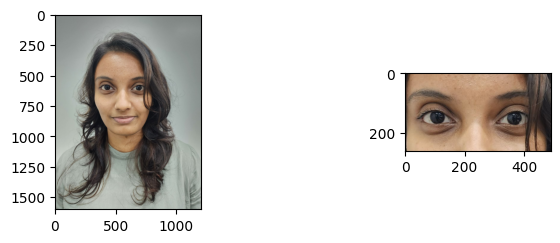

In [122]:
image_path = '/Users/raminduwalgama/Downloads/WhatsApp Image 2023-10-02 at 15.51.17 (1).jpeg'
# image_path = '/Users/raminduwalgama/Downloads/images-1.jpeg'
# image_path = '/Users/raminduwalgama/Documents/Projects/OneID/icao-guidelines-server/dataset/invalid/hair_cross.jpeg'
# image_path = '/Users/raminduwalgama/Documents/Projects/OneID/icao-guidelines-server/dataset/valid/N231600941.JPG'
plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
face_landmarks = get_face_landmarks(image_path)

EYEBROW = list(set([index for pair in mp.solutions.face_mesh.FACEMESH_RIGHT_EYEBROW for index in pair]))
FACE = list(set([index for pair in mp.solutions.face_mesh.FACEMESH_FACE_OVAL for index in pair]))
NOSE = list(set([index for pair in mp.solutions.face_mesh.FACEMESH_NOSE for index in pair]))


def crop_eye_region(image_path, landmarks, padding=0):
    image = cv2.imread(image_path)
    # image = np.rot90(image)
    height, width = image.shape[:2]
    x_coordinates = [int(landmarks[point].x * width) for point in FACE]
    eyebrow_y_coords = [int(landmarks[point].y * height) for point in EYEBROW]
    nose_y_coords = [int(landmarks[point].y * height) for point in NOSE]
    x_min, x_max = min(x_coordinates), max(x_coordinates)
    y_min, y_max = min(eyebrow_y_coords), max(nose_y_coords)
    y_min = int(y_min*0.9)
    y_max = int(y_max*0.9)
    cropped_image = image[y_min-padding:y_max+padding, x_min-padding:x_max+padding]
    return cropped_image


eye_region = crop_eye_region(image_path=image_path, landmarks=face_landmarks)
plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(eye_region, cv2.COLOR_BGR2RGB))
plt.show()


## Try different Gradient Modulus
Sobel Operator: Similar to the Prewitt operator but with different kernel values.
Scharr Operator: Another gradient operator that might give better results in some cases.
Laplacian: Computes the Laplacian of the image, which can also be used for edge detection.

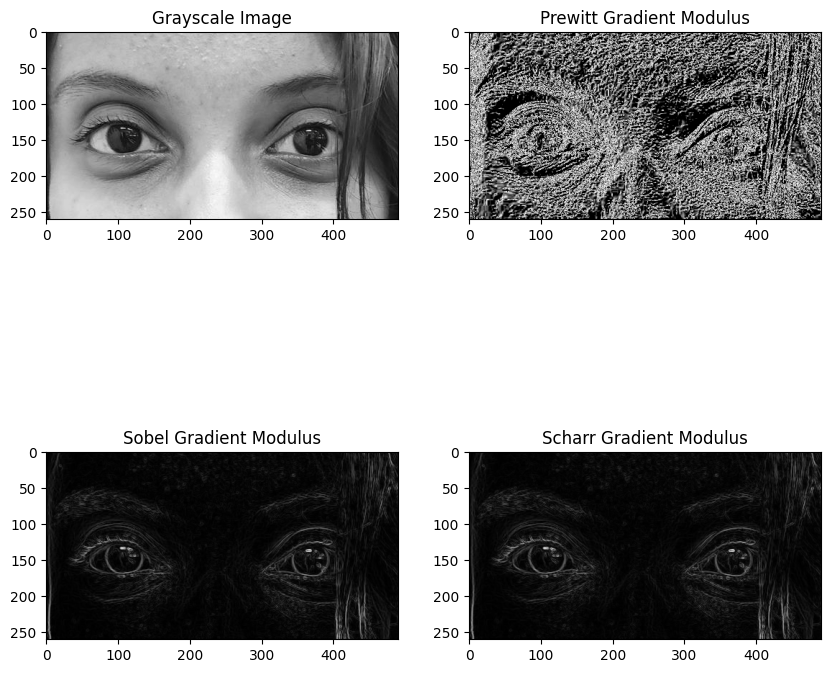

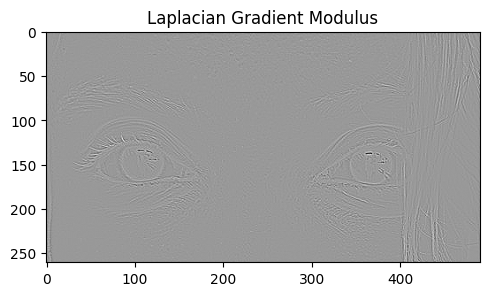

In [123]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def plot_gradient_modulus(eye_region):
    # Convert the image to grayscale if it's not already
    if len(eye_region.shape) == 3:
        eye_region = cv2.cvtColor(eye_region, cv2.COLOR_BGR2GRAY)
    # Plot grayscale image
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 2, 1)
    plt.imshow(eye_region, cmap='gray')
    plt.title('Grayscale Image')

    # Prewitt Operator (Already provided)
    kernel_x_prewitt = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
    kernel_y_prewitt = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    grad_x_prewitt = cv2.filter2D(eye_region, -1, kernel_x_prewitt)
    grad_y_prewitt = cv2.filter2D(eye_region, -1, kernel_y_prewitt)
    gradient_modulus_prewitt = np.sqrt(grad_x_prewitt**2 + grad_y_prewitt**2)

    # Sobel Operator
    grad_x_sobel = cv2.Sobel(eye_region, cv2.CV_64F, 1, 0, ksize=3)
    grad_y_sobel = cv2.Sobel(eye_region, cv2.CV_64F, 0, 1, ksize=3)
    gradient_modulus_sobel = np.sqrt(grad_x_sobel**2 + grad_y_sobel**2)

    # Scharr Operator
    grad_x_scharr = cv2.Scharr(eye_region, cv2.CV_64F, 1, 0)
    grad_y_scharr = cv2.Scharr(eye_region, cv2.CV_64F, 0, 1)
    gradient_modulus_scharr = np.sqrt(grad_x_scharr**2 + grad_y_scharr**2)

    # Laplacian
    gradient_modulus_laplacian = cv2.Laplacian(eye_region, cv2.CV_64F)

    # Plotting
    plt.subplot(2, 2, 2)
    plt.imshow(gradient_modulus_prewitt, cmap='gray')
    plt.title('Prewitt Gradient Modulus')

    plt.subplot(2, 2, 3)
    plt.imshow(gradient_modulus_sobel, cmap='gray')
    plt.title('Sobel Gradient Modulus')

    plt.subplot(2, 2, 4)
    plt.imshow(gradient_modulus_scharr, cmap='gray')
    plt.title('Scharr Gradient Modulus')

    # Uncomment this if you want to see the Laplacian (requires another figure)
    plt.figure(figsize=(5, 5))
    plt.imshow(gradient_modulus_laplacian, cmap='gray')
    plt.title('Laplacian Gradient Modulus')

    plt.tight_layout()
    plt.show()


plot_gradient_modulus(eye_region)


## Algorithm - Pixelation Detection
### Sobel Operator with Hough Lines

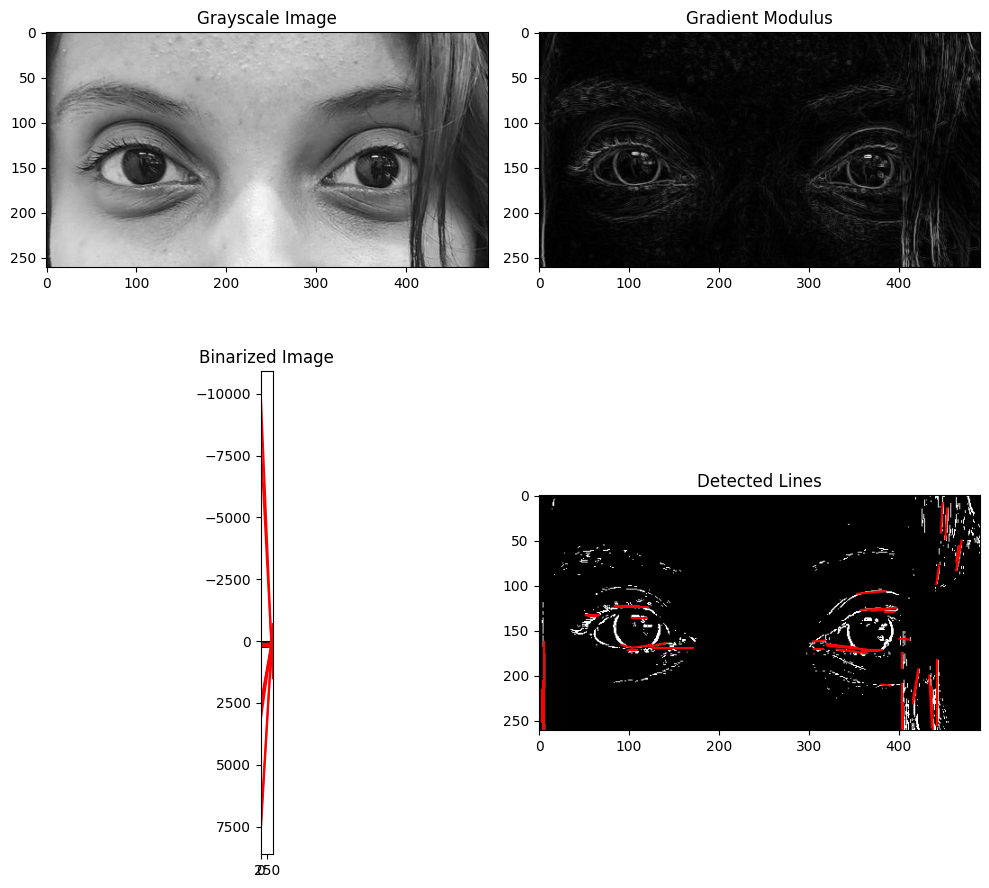

Compliance Score: 2.0


In [124]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compute_compliance_score(eye_region):
    # Convert the image to grayscale if it's not already
    if len(eye_region.shape) == 3:
        eye_region = cv2.cvtColor(eye_region, cv2.COLOR_BGR2GRAY)
    # Plot grayscale image
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 2, 1)
    plt.imshow(eye_region, cmap='gray')
    plt.title('Grayscale Image')

    # # 1. Calculate the gradient modulus using the Prewitt operator
    # kernel_x = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
    # kernel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    # grad_x = cv2.filter2D(eye_region, -1, kernel_x)
    # grad_y = cv2.filter2D(eye_region, -1, kernel_y)
    # gradient_modulus = np.sqrt(grad_x**2 + grad_y**2)

    # Sobel Operator
    grad_x_sobel = cv2.Sobel(eye_region, cv2.CV_64F, 1, 0, ksize=3)
    grad_y_sobel = cv2.Sobel(eye_region, cv2.CV_64F, 0, 1, ksize=3)
    gradient_modulus_sobel = np.sqrt(grad_x_sobel**2 + grad_y_sobel**2)

    # Convert gradient modulus to float32
    gradient_modulus = gradient_modulus_sobel.astype(np.float32)

    # Normalize the gradient modulus to range [0, 255]
    gradient_modulus_normalized = cv2.normalize(gradient_modulus, None, 0, 255, cv2.NORM_MINMAX)

    # Convert normalized gradient modulus to 8-bit image
    gradient_modulus_8bit = np.uint8(gradient_modulus_normalized)
    # Plot gradient modulus
    plt.subplot(2, 2, 2)
    plt.imshow(gradient_modulus, cmap='gray')
    plt.title('Gradient Modulus')


    # Now, apply the threshold
    _, binarized = cv2.threshold(gradient_modulus_8bit, 50, 255, cv2.THRESH_BINARY)

    # Plot binarized image
    plt.subplot(2, 2, 3)
    plt.imshow(binarized, cmap='gray')
    plt.title('Binarized Image')

    # 3. Detect lines using the Hough transform
    lines = cv2.HoughLinesP(binarized, 1, np.pi / 180, threshold=50, minLineLength=10, maxLineGap=5)


    # 4. Count the number of horizontal and vertical lines
    horizontal_count = 0
    vertical_count = 0

    # Convert the binarized image to a 3-channel image
    binarized_rgb = binarized.copy()
    binarized_rgb = cv2.cvtColor(binarized_rgb, cv2.COLOR_GRAY2RGB)

    if lines is not None:
        for line in lines[:, 0]:
            x1, y1, x2, y2 = line
            # Calculate slope and intercept
            if x2 - x1 == 0:  # vertical line
                plt.plot([x1, x1], [0, binarized_rgb.shape[0]-1], 'r')
                vertical_count += 1
            else:
                m = (y2 - y1) / (x2 - x1)
                b = y1 - m * x1
                y_start = int(m * 0 + b)
                y_end = int(m * binarized_rgb.shape[1] + b)
                plt.plot([0, binarized_rgb.shape[1]-1], [y_start, y_end], 'r')
                angle = np.arctan2(y2 - y1, x2 - x1) * 180.0 / np.pi
                if (-5 <= angle <= 5) or (angle <= -175 or angle >= 175):
                    horizontal_count += 1
                else:
                    vertical_count += 1


    # Plot the binarized image with the detected red lines
    plt.subplot(2, 2, 4)
    plt.imshow(binarized_rgb)
    plt.title('Detected Lines')

    if lines is not None:
        plt.subplot(2, 2, 4)
        plt.imshow(binarized, cmap='gray')
        for line in lines[:, 0]:
            x1, y1, x2, y2 = line
            plt.plot([x1, x2], [y1, y2], 'r')
        plt.title('Detected Lines')


    plt.tight_layout()
    plt.show()
    # 5. Calculate the compliance score
    # total_lines = horizontal_count + vertical_count
    # compliance_score = 1 / (1 + total_lines)

    compliance_score = vertical_count / horizontal_count

    return compliance_score

# Assuming eye_region is already defined
score = compute_compliance_score(eye_region)
print(f"Compliance Score: {score}")


Compliance Score: 0.023255813953488372

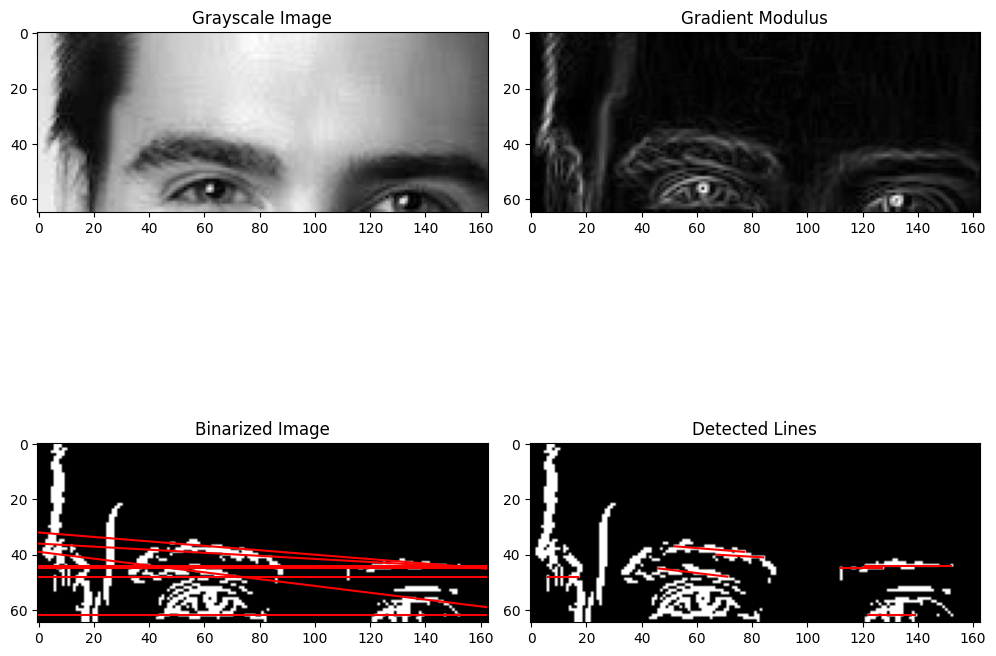

Compliance Score: 0.16666666666666666


In [125]:
image_path = '/Users/raminduwalgama/Downloads/id-photo2.jpg'
eye_region = crop_eye_region(image_path=image_path, landmarks=face_landmarks)

score = compute_compliance_score(eye_region)
print(f"Compliance Score: {score}")

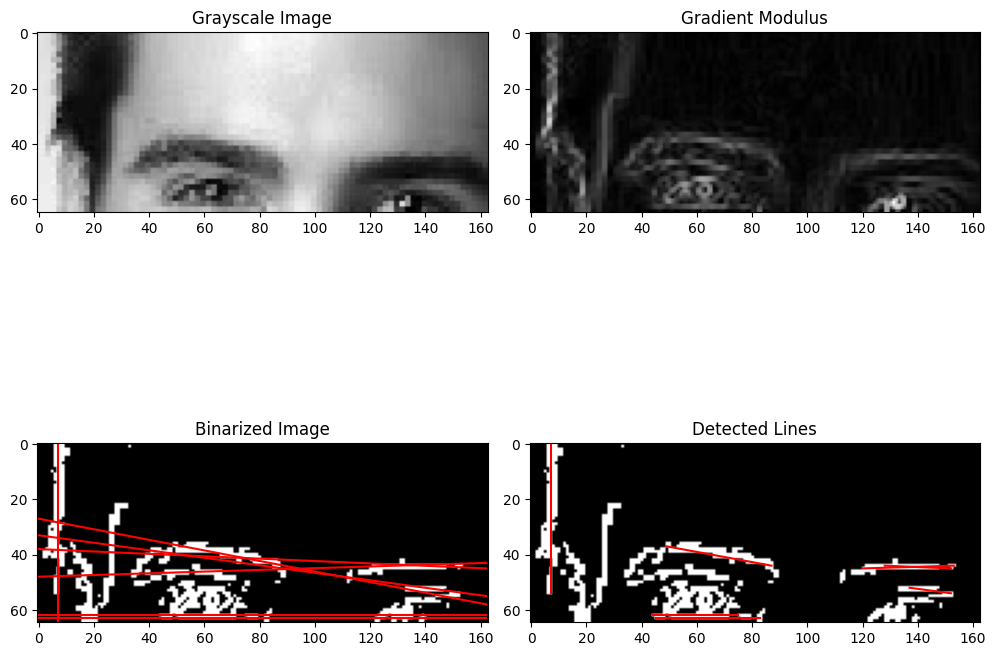

Compliance Score: 0.75
/Users/raminduwalgama/Downloads/image-2.jpg


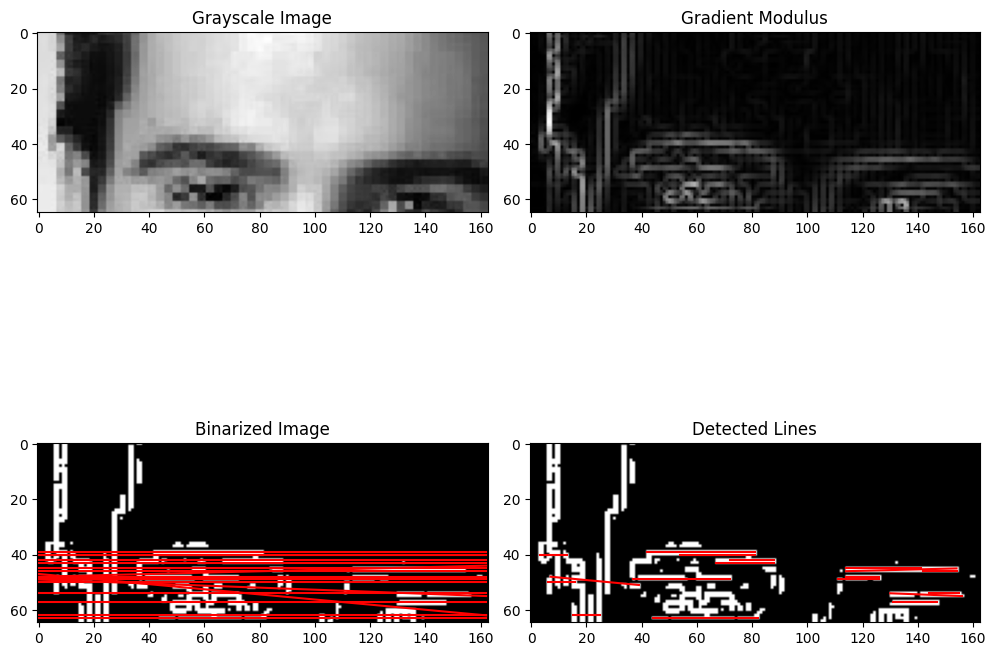

Compliance Score 2: 0.058823529411764705
/Users/raminduwalgama/Downloads/image-3.jpg


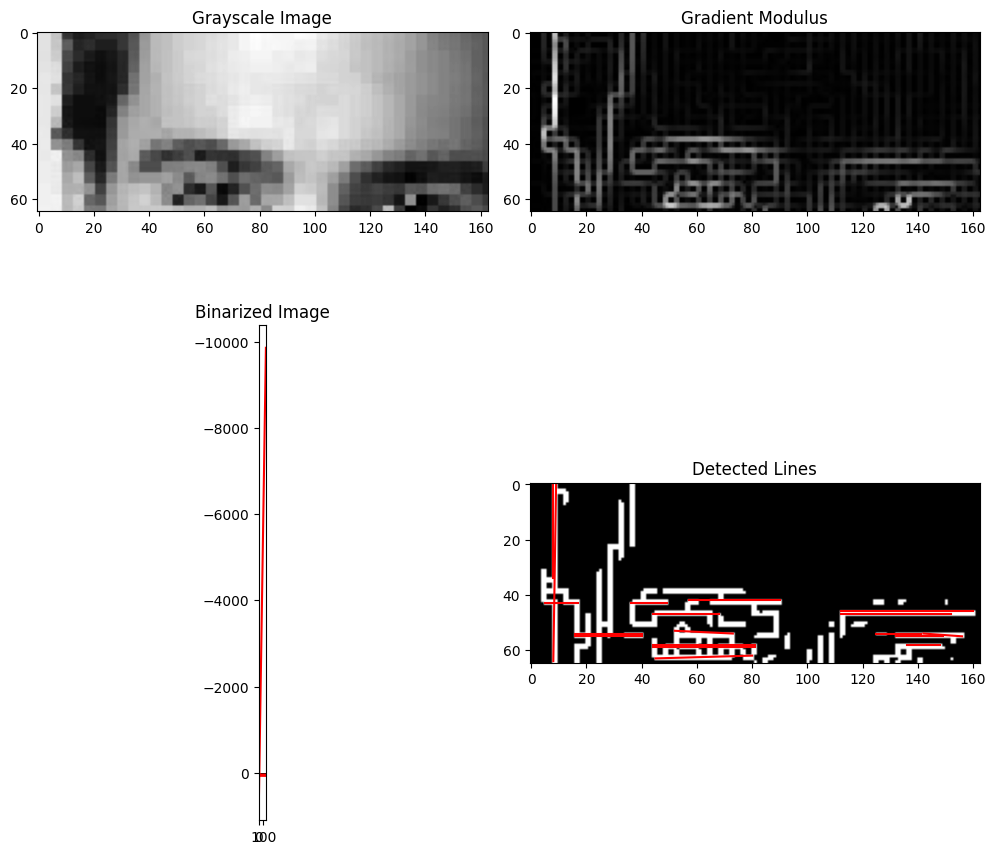

Compliance Score 3: 0.125
/Users/raminduwalgama/Downloads/image-4.jpg


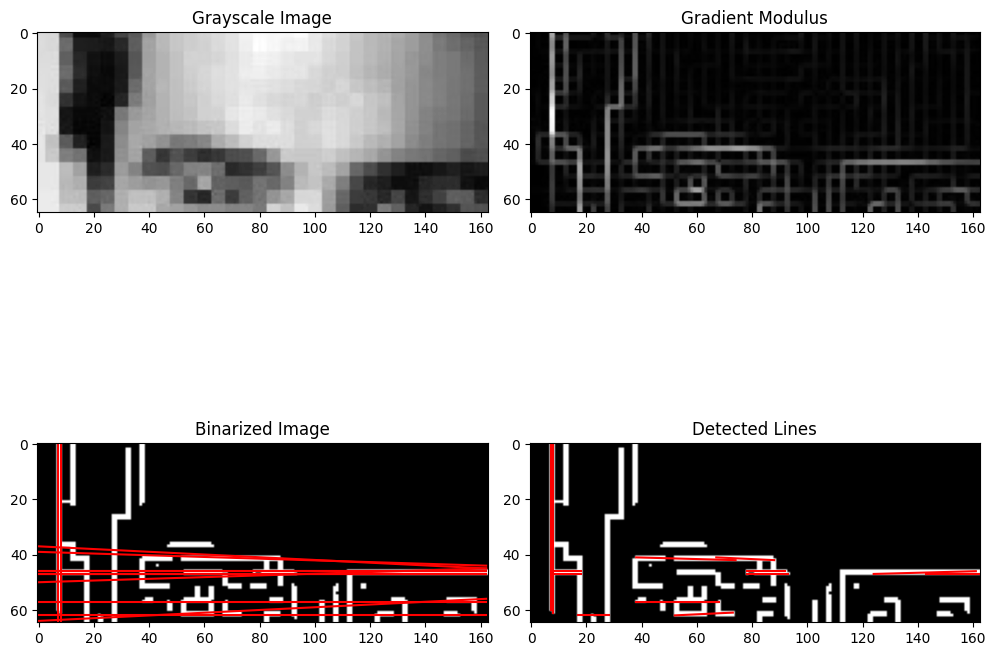

Compliance Score 4: 0.18181818181818182
/Users/raminduwalgama/Downloads/image-5.jpg


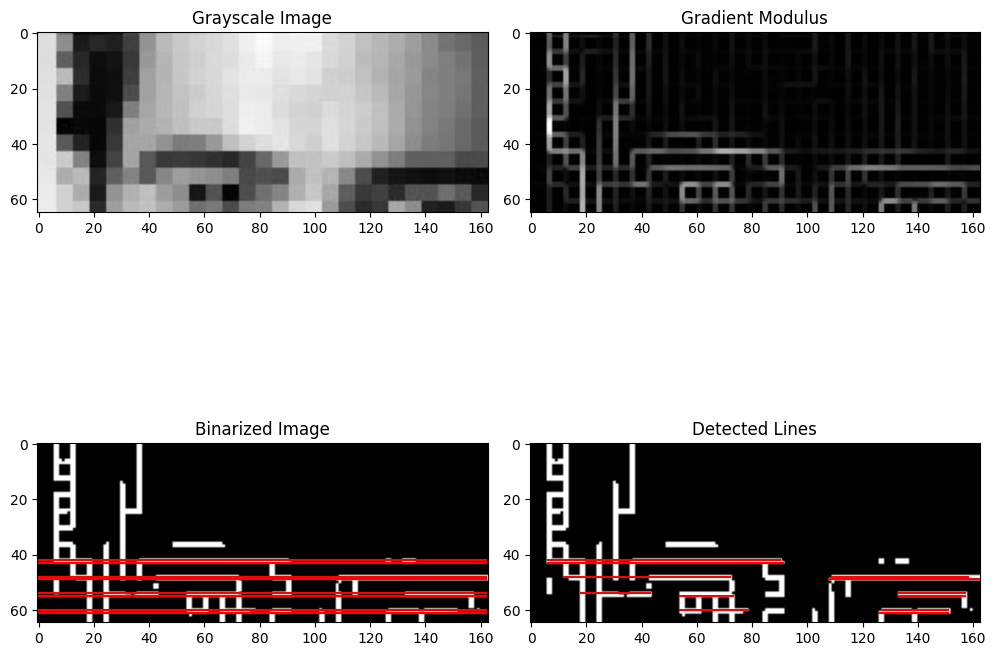

Compliance Score 5: 0.0
/Users/raminduwalgama/Downloads/image-6.jpg


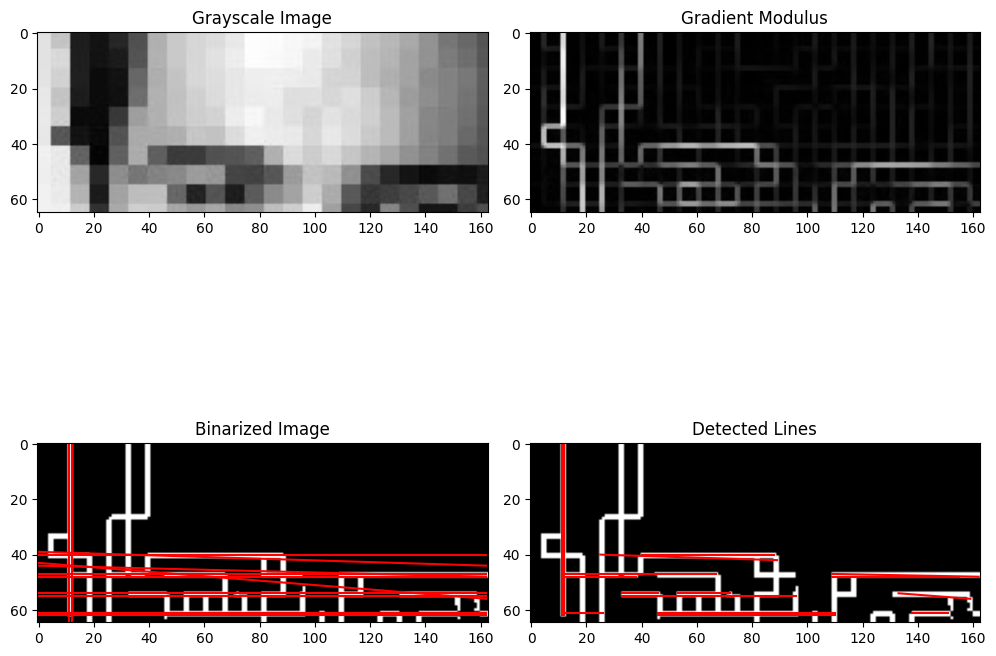

Compliance Score 6: 0.14285714285714285


In [126]:
image_path = '/Users/raminduwalgama/Downloads/image'
eye_region = crop_eye_region(image_path=image_path+".jpg", landmarks=face_landmarks)
score = compute_compliance_score(eye_region)
print(f"Compliance Score: {score}")

for i in range(2,7):
    print(image_path+f"-{i}.jpg")
    eye_region = crop_eye_region(image_path=image_path+f"-{i}.jpg", landmarks=face_landmarks)
    score = compute_compliance_score(eye_region)
    print(f"Compliance Score {i}: {score}")

In [105]:
EYEBROW = list(set([index for pair in mp.solutions.face_mesh.FACEMESH_RIGHT_EYEBROW for index in pair]))
FACE = list(set([index for pair in mp.solutions.face_mesh.FACEMESH_FACE_OVAL for index in pair]))
NOSE = list(set([index for pair in mp.solutions.face_mesh.FACEMESH_NOSE for index in pair]))

def compute_compliance_score(eye_region):
    # Convert the image to grayscale if it's not already
    if len(eye_region.shape) == 3:
        eye_region = cv2.cvtColor(eye_region, cv2.COLOR_BGR2GRAY)

    # # 1. Calculate the gradient modulus using the Prewitt operator
    # kernel_x = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
    # kernel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    # grad_x = cv2.filter2D(eye_region, -1, kernel_x)
    # grad_y = cv2.filter2D(eye_region, -1, kernel_y)
    # gradient_modulus = np.sqrt(grad_x**2 + grad_y**2)

    # Sobel Operator
    grad_x_sobel = cv2.Sobel(eye_region, cv2.CV_64F, 1, 0, ksize=3)
    grad_y_sobel = cv2.Sobel(eye_region, cv2.CV_64F, 0, 1, ksize=3)
    gradient_modulus_sobel = np.sqrt(grad_x_sobel**2 + grad_y_sobel**2)

    # Convert gradient modulus to float32
    gradient_modulus = gradient_modulus_sobel.astype(np.float32)

    # Normalize the gradient modulus to range [0, 255]
    gradient_modulus_normalized = cv2.normalize(gradient_modulus, None, 0, 255, cv2.NORM_MINMAX)

    # Convert normalized gradient modulus to 8-bit image
    gradient_modulus_8bit = np.uint8(gradient_modulus_normalized)

    # Now, apply the threshold
    _, binarized = cv2.threshold(gradient_modulus_8bit, 50, 255, cv2.THRESH_BINARY)

    # 3. Detect lines using the Hough transform
    lines = cv2.HoughLinesP(binarized, 1, np.pi / 180, threshold=50, minLineLength=10, maxLineGap=5)

    # 4. Count the number of horizontal and vertical lines
    horizontal_count = 0
    vertical_count = 0

    if lines is not None:
        for line in lines[:, 0]:
            x1, y1, x2, y2 = line
            # Calculate slope and intercept
            if x2 - x1 == 0:  # vertical line
                vertical_count += 1
            else:
                angle = np.arctan2(y2 - y1, x2 - x1) * 180.0 / np.pi
                if (-5 <= angle <= 5) or (angle <= -175 or angle >= 175):
                    horizontal_count += 1
                else:
                    vertical_count += 1
    # 5. Calculate the compliance score
    # total_lines = horizontal_count + vertical_count
    # compliance_score = 1 / (1 + total_lines)
    if horizontal_count == 0:
        horizontal_count = 1
    compliance_score = vertical_count / horizontal_count

    return compliance_score



In [106]:
from datetime import datetime
import pandas as pd

def logger(image, compliance_score, path="./"):
    time_str = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
    df_headers = pd.DataFrame({
        'log_time': [time_str],
        'image': [image],
        'compliance_score': compliance_score
    })
    if not os.path.isfile(f'{path}pixelation.csv'):
        df_headers.to_csv(f'{path}pixelation.csv', mode='w', index=False)
    else:
        df_headers.to_csv(f'{path}pixelation.csv', mode='a', index=False, header=False)

In [107]:
from datetime import datetime

start_time = datetime.now()

for j in range(0, int(len(all_images))):
    image_name = all_images[j]
    face_landmarks = get_face_landmarks(image_name)
    eye_region = crop_eye_region(image_name, face_landmarks)
    compliance_score = compute_compliance_score(eye_region)
    logger(image_name, compliance_score)


print("------------------COMPLETED------------------")

end_time = datetime.now()
print('Unit: seconds')
print('Duration: {}'.format(end_time - start_time))
print('Duration per image: {}'.format((end_time - start_time)/len(all_images)))

score = compute_compliance_score(eye_region)
print(f"Compliance Score: {score}")


W20231101 13:22:42.194689 2710074 face_landmarker_graph.cc:168] Face blendshape model contains CPU only ops. Sets FaceBlendshapesGraph acceleration to Xnnpack.
W20231101 13:22:42.254698 2710074 face_landmarker_graph.cc:168] Face blendshape model contains CPU only ops. Sets FaceBlendshapesGraph acceleration to Xnnpack.
W20231101 13:22:42.296983 2710074 face_landmarker_graph.cc:168] Face blendshape model contains CPU only ops. Sets FaceBlendshapesGraph acceleration to Xnnpack.
W20231101 13:22:42.338658 2710074 face_landmarker_graph.cc:168] Face blendshape model contains CPU only ops. Sets FaceBlendshapesGraph acceleration to Xnnpack.
W20231101 13:22:42.379720 2710074 face_landmarker_graph.cc:168] Face blendshape model contains CPU only ops. Sets FaceBlendshapesGraph acceleration to Xnnpack.
W20231101 13:22:42.422998 2710074 face_landmarker_graph.cc:168] Face blendshape model contains CPU only ops. Sets FaceBlendshapesGraph acceleration to Xnnpack.
W20231101 13:22:42.466843 2710074 face_l

------------------COMPLETED------------------
Unit: seconds
Duration: 0:00:21.733087
Duration per image: 0:00:00.043466
Compliance Score: 0.2857142857142857


W20231101 13:23:03.756472 2710074 face_landmarker_graph.cc:168] Face blendshape model contains CPU only ops. Sets FaceBlendshapesGraph acceleration to Xnnpack.
W20231101 13:23:03.799155 2710074 face_landmarker_graph.cc:168] Face blendshape model contains CPU only ops. Sets FaceBlendshapesGraph acceleration to Xnnpack.
W20231101 13:23:03.842221 2710074 face_landmarker_graph.cc:168] Face blendshape model contains CPU only ops. Sets FaceBlendshapesGraph acceleration to Xnnpack.
W20231101 13:23:03.882138 2710074 face_landmarker_graph.cc:168] Face blendshape model contains CPU only ops. Sets FaceBlendshapesGraph acceleration to Xnnpack.


In [108]:
df = pd.read_csv('./pixelation.csv')
df.describe()

,compliance_score
count,500.000000
mean,0.474938
std,0.573134
min,0.000000
25%,0.125000
50%,0.333333
75%,0.615385
max,5.500000


In [109]:
print(len(df[df["compliance_score"]==0]))


82
